In [ ]:
# Feature Selection: Select a subset of input features from the dataset.
# Unsupervised: Do not use the target variable (e.g. remove redundant variables).
# Correlation
# Supervised: Use the target variable (e.g. remove irrelevant variables).
# Wrapper: Search for well-performing subsets of features.
# RFE
# Filter: Select subsets of features based on their relationship with the target.
# Statistical Methods
# Feature Importance Methods
# Intrinsic: Algorithms that perform automatic feature selection during training.
# Decision Trees
# Dimensionality Reduction: Project input data into a lower-dimensional feature space.

# https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/

In [1]:
# Core
import pandas as pd
import os
import numpy as np
from numpy import set_printoptions, sqrt, argmax, arange
from numpy.random import permutation
import scipy.stats as stats
from itertools import compress
import matplotlib.pyplot as plt
import seaborn as sns
import time

#tsfresh
import tsfresh
from tsfresh.feature_extraction import extract_features, MinimalFCParameters, EfficientFCParameters
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

# Sklearn
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, chi2
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, precision_recall_curve
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve, roc_curve, ConfusionMatrixDisplay
from sklearn.utils import resample
from sklearn.decomposition import PCA

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Self-defined functions
from Utilities import pdVarianceThreshold, pdSelectKBest, train_val_test_split, upsampling, SelectBestClf

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
direc = "E:\\WS4PD_data"
os.chdir(direc)
save_path = os.path.join(direc, "Model_validation", "GENEActiv_tremor")

# Load data

In [3]:
## Load scores
score_file_path = os.path.join(direc, 'Feature_extraction','score_by_device.pkl')
df_score = pd.read_pickle(score_file_path)

# Tremor: merge score 3 and 4
df_score['tremor_GENEActivHand'].loc[df_score['tremor_GENEActivHand']==4]=3
print('df_score:')
print(df_score.shape)

## load sensor features
subject_ids = df_score.subject_id.unique()
df_sensor_feature = pd.DataFrame()
device = 'GENEActiv'
for sb in subject_ids:
    feature_file_path = os.path.join(direc,'Feature_extraction',device,sb + '_features.pkl')
    df_sensor_feature_sb = pd.read_pickle(feature_file_path)
    df_sensor_feature = pd.concat([df_sensor_feature,df_sensor_feature_sb])
df_sensor_feature = df_sensor_feature.reset_index(drop=True)
df_sensor_feature = df_sensor_feature.dropna(axis=1)
print('df_sensor_feature:')
print(df_sensor_feature.shape)

## load clinical features
meta_file_path = os.path.join(direc, 'Feature_extraction','metadata_features.pkl')
df_clinical_feature = pd.read_pickle(meta_file_path)

# drop subject_id and task_code 
# df_clinical_feature.drop(columns = ['subject_id', 'task_code'])
df_clinical_feature = df_clinical_feature.drop(columns = 'subject_id')

# One-hot encoding clinical/ categorical features
categorical_columns = df_clinical_feature.columns
for column in categorical_columns:
    tempdf = pd.get_dummies(df_clinical_feature[column], prefix=column)
    df_clinical_feature = pd.merge(
        left=df_clinical_feature,
        right=tempdf,
        left_index=True,
        right_index=True,
    )
    df_clinical_feature = df_clinical_feature.drop(columns=column)
df_clinical_feature = df_clinical_feature.dropna(axis=1)
print('df_clinical_feature:')
print(df_clinical_feature.shape)

df_score:
(6909, 11)
df_sensor_feature:
(6909, 2247)
df_clinical_feature:
(6909, 69)


In [4]:
# Create a new label for each question

# Tremor
# 1. Can wearable sensor data predict tremor score? 
# df_score['newTremorLabel_GENEActivHand'] = df_score['tremor_GENEActivHand']
# title_name = 'Tremor score'
# save_name = 'tremor_score'
# xtick_name = [0,1,2,3,4]
# bin_range = range(5)

# 2. Can wearable sensor data predict whether tremor is present?
is_tremor = df_score['tremor_GENEActivHand'].astype(int)>0
df_score['newTremorLabel_GENEActivHand'] = np.nan
df_score['newTremorLabel_GENEActivHand'].loc[is_tremor] = 1
df_score['newTremorLabel_GENEActivHand'].loc[~is_tremor] = 0

title_name = 'is tremor'
save_name = 'is_tremor'
xtick_name = [0,1]
bin_range = range(3)
recall_1_threshold = 0.8

# 3. Can wearable sensor data predict whether tremor symptom is sever (score>2)? 
# is_sever_tremor = df_score['tremor_GENEActivHand'].astype(int)>2
# df_score['newTremorLabel_GENEActivHand'] = np.nan
# df_score['newTremorLabel_GENEActivHand'].loc[is_sever_tremor] = 1
# df_score['newTremorLabel_GENEActivHand'].loc[~is_sever_tremor] = 0

# title_name = 'is sever tremor (tremor score>2)'
# save_name = 'is_sever_tremor'
# xtick_name = [0,1]
# bin_range = range(3)
# recall_1_threshold = 0.9

array([4677, 2232], dtype=int64)

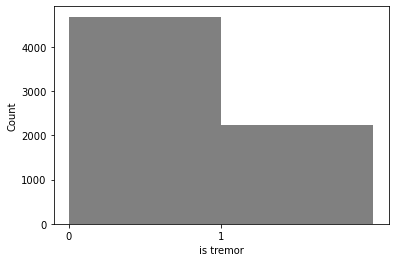

In [5]:
# Get new score distribution
score = df_score['newTremorLabel_GENEActivHand'].values
score = np.array(score, dtype=float)

# score distribution
counts, bin_edges = np.histogram(score,bins = bin_range)
fig, ax = plt.subplots()
ax.hist(score, bins = bin_range, histtype='bar', color = 'grey')
ax.set_xlabel(title_name)
ax.set_ylabel('Count')
ax.set_xticks(xtick_name)
# save figure
# plt.savefig(os.path.join(save_path,"Tremor_score_distribution"))
counts

# Feature selection

In [6]:
varThreshold = 0.0001
# Remove features with zero variance
df_sensor_feature = pdVarianceThreshold(df_sensor_feature,varThreshold)
df_clinical_feature = pdVarianceThreshold(df_clinical_feature,varThreshold)


In [7]:
# All dataset
df_selected_sensor_all = pdSelectKBest(df_sensor_feature,score, f_classif, 20)
df_selected_sensor_all.columns

Index(['x__ar_coefficient__k_10__coeff_2', 'x__ar_coefficient__k_10__coeff_3',
       'x__ar_coefficient__k_10__coeff_4', 'x__has_duplicate',
       'x__percentage_of_reoccurring_datapoints_to_all_datapoints',
       'x__percentage_of_reoccurring_values_to_all_values',
       'x__ratio_value_number_to_time_series_length',
       'x__sum_of_reoccurring_data_points', 'x__sum_of_reoccurring_values',
       'y__percentage_of_reoccurring_datapoints_to_all_datapoints',
       'y__percentage_of_reoccurring_values_to_all_values',
       'y__ratio_value_number_to_time_series_length',
       'z__ar_coefficient__k_10__coeff_2', 'z__ar_coefficient__k_10__coeff_3',
       'z__ar_coefficient__k_10__coeff_4', 'z__partial_autocorrelation__lag_4',
       'z__percentage_of_reoccurring_datapoints_to_all_datapoints',
       'z__percentage_of_reoccurring_values_to_all_values',
       'z__quantile__q_0.2', 'z__ratio_value_number_to_time_series_length'],
      dtype='object', name='variable')

In [11]:
# Train/Validation/Test Split
subject_id = df_score['subject_id']
X_train_valid, y_train_valid, X_train, y_train,  X_valid, y_valid, X_test, y_test = train_val_test_split(df_selected_sensor_all, score, subject_id)


In [19]:
# Train dataset
# Train/Validation/Test Split
subject_id = df_score['subject_id']
X_train_valid, y_train_valid, X_train, y_train,  X_valid, y_valid, X_test, y_test = train_val_test_split(df_sensor_feature, score, subject_id)

X_train_sf = pdSelectKBest(X_train, y_train, f_classif, 20)
sf_index = X_train_sf.columns
X_valid_sf = X_valid.loc[:,sf_index]

C:\Users\Yiting\Anaconda3\envs\ws4pd\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 688  692  693 2093] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\Yiting\Anaconda3\envs\ws4pd\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [ ]:
# df_sensor_feature: numerical input
# df_clinical_feature: categorical input
# score: categorical output


# SelectKBest
df_selected_sensor = pdSelectKBest(df_sensor_feature,score, f_classif, 20)
df_selected_clinical = pdSelectKBest(df_clinical_feature,score, chi2, 5)



In [ ]:
df_selected_sensor.columns

In [ ]:
# Combine sensor features with clinical features
df = pd.concat([df_sensor_feature, df_clinical_feature], axis=1) 
df = df.dropna(axis=1)

# Train/Validation/Test Split
subject_id = df_score['subject_id']
X_train_valid, y_train_valid, X_train, y_train,  X_valid, y_valid, X_test, y_test = train_val_test_split(df, score, subject_id)


# tsfresh builtin feature selection 

In [ ]:
# tsfresh builtin feature selection 
X_selected = select_features(X_train, y_train)
selected_features = X_selected.columns


In [ ]:
selected_features

# Univariant selection

In [ ]:
# Univariant selection
df3 = pdSelectKBest(X_selected,y_train,20)

In [ ]:
df3.columns

# Feature Importance

In [ ]:
# Feature importance using ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X_selected,y_train)
# print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_selected.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [ ]:
# Feature importance using Random Forest
# evaluation of a model using 5 features chosen with random forest importance
from sklearn.feature_selection import SelectFromModel
 
# feature selection function
def select_features(X_train, y_train, X_test):
    # configure to select a subset of features
    fs = SelectFromModel(RandomForestClassifier(n_estimators=1000), max_features=10)
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs
 
# feature selection
X_train_fs, X_valid_fs, fs = select_features(X_train, y_train, X_valid)
# fit the model
model = LogisticRegression(solver='liblinear')
model.fit(X_train_fs, y_train)
# evaluate the model
y_pred = model.predict(X_valid_fs)

# evaluate predictions
F1_micro = f1_score(y_valid, y_pred, average = 'micro').round(2)
print('F1 score: %.2f' % (F1_micro*100))

In [10]:
# Classifiers
classifiers = {
    "LogisticRegression" : LogisticRegression(random_state=0, solver = 'liblinear'),
    "KNN" : KNeighborsClassifier(),
#     "SVC" : SVC(random_state=0, probability=True),
    "RandomForest" : RandomForestClassifier(random_state=0),
    "XGBoost" : XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss'), # XGBoost takes too long
    "LGBM" : LGBMClassifier(random_state=0),
#     "CatBoost" : CatBoostClassifier(random_state=0, verbose=False),
    "NaiveBayes": GaussianNB()
}

# Grids for grid search
LR_grid = {'penalty': ['l1','l2'],
           'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
           'max_iter': [50, 100, 150, 200, 250]}

KNN_grid = {'n_neighbors': [3, 5, 7, 9],
            'p': [1, 2]}

# SVC_grid = {'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
#             'kernel': ['linear', 'rbf'],
#             'gamma': ['scale', 'auto']}

RF_grid = {'n_estimators': [50, 100, 150, 200, 250, 300],
        'max_depth': [2, 4, 6, 8, 10, 12]}

boosted_grid = {'n_estimators': [50, 100, 150, 200],
        'max_depth': [4, 8, 12],
        'learning_rate': [0.05, 0.1, 0.15]}

NB_grid={'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7]}

# Dictionary of all grids
grid = {
    "LogisticRegression" : LR_grid,
    "KNN" : KNN_grid,
#     "SVC" : SVC_grid,
    "RandomForest" : RF_grid,
    "XGBoost" : boosted_grid,
    "LGBM" : boosted_grid,
#     "CatBoost" : boosted_grid,
    "NaiveBayes": NB_grid
}

In [20]:
# Classifier evaluation
i=0
clf_best_params=classifiers.copy()
valid_scores=pd.DataFrame({'Classifer':classifiers.keys(),
                           'Accuracy': np.zeros(len(classifiers)),
                           'F1_macro': np.zeros(len(classifiers)),
                           'F1_micro': np.zeros(len(classifiers)),
                           'F1_weighted': np.zeros(len(classifiers)),
                           'F1_0': np.zeros(len(classifiers)),
                           'F1_1': np.zeros(len(classifiers)),                               
                           'Precision_0': np.zeros(len(classifiers)),
                           'Precision_1': np.zeros(len(classifiers)),
                           'Recall_0': np.zeros(len(classifiers)),
                           'Recall_1': np.zeros(len(classifiers)),
                           'Training time': np.zeros(len(classifiers))})
for key, classifier in classifiers.items():
    start = time.time()
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=None)

    # Train and score
    clf.fit(X_train_sf, y_train)
    y_pred = clf.predict(X_valid_sf)
    Accuracy = accuracy_score(y_valid, y_pred).round(2)
    F1_macro = f1_score(y_valid, y_pred, average = 'macro').round(2)
    F1_micro = f1_score(y_valid, y_pred, average = 'micro').round(2)
    F1_weighted = f1_score(y_valid, y_pred, average = 'weighted').round(2)
    F1_class = f1_score(y_valid, y_pred, average = None).round(2)
    Precision = precision_score(y_valid, y_pred, average = None).round(2)
    Recall = recall_score(y_valid, y_pred, average = None).round(2)                                         

    valid_scores.iloc[i,1]=Accuracy
    valid_scores.iloc[i,2]=F1_macro
    valid_scores.iloc[i,3]=F1_micro
    valid_scores.iloc[i,4]=F1_weighted
    valid_scores.iloc[i,5]=F1_class[0]
    valid_scores.iloc[i,6]=F1_class[1]
    valid_scores.iloc[i,7]=Precision[0]
    valid_scores.iloc[i,8]=Precision[1] 
    valid_scores.iloc[i,9]=Recall[0]
    valid_scores.iloc[i,10]=Recall[1]

    # Save trained model
    clf_best_params[key]=clf.best_params_

    # Print iteration and training time
    stop = time.time()
    valid_scores.iloc[i,11]=np.round((stop - start)/60, 2)


    print('Model:', key)
    print('Training time (mins):', valid_scores.iloc[i,11])
    print('')
    i+=1


Model: LogisticRegression
Training time (mins): 0.13

Model: KNN
Training time (mins): 0.02

Model: RandomForest
Training time (mins): 0.39

Model: XGBoost
Training time (mins): 0.78

Model: LGBM
Training time (mins): 0.12

Model: NaiveBayes
Training time (mins): 0.0



In [21]:
valid_scores

,Classifer,Accuracy,F1_macro,F1_micro,F1_weighted,F1_0,F1_1,Precision_0,Precision_1,Recall_0,Recall_1,Training time
0,LogisticRegression,0.70,0.64,0.70,0.68,0.79,0.48,0.74,0.58,0.84,0.42,0.13
1,KNN,0.68,0.63,0.68,0.68,0.77,0.49,0.74,0.54,0.81,0.45,0.02
2,RandomForest,0.75,0.72,0.75,0.75,0.81,0.62,0.80,0.63,0.82,0.61,0.39
3,XGBoost,0.75,0.71,0.75,0.75,0.81,0.61,0.80,0.64,0.83,0.59,0.78
4,LGBM,0.74,0.70,0.74,0.74,0.81,0.60,0.79,0.64,0.83,0.56,0.12
5,NaiveBayes,0.72,0.69,0.72,0.72,0.79,0.59,0.79,0.59,0.79,0.58,0.00


In [22]:
best_clf_summary = SelectBestClf(valid_scores, recall_1_threshold, clf_best_params)
best_clf = best_clf_summary[2]
print(best_clf)

RandomForest


In [ ]:
## Get data
# Combine sensor features with clinical features
df = pd.concat([df_sensor_feature, df_clinical_feature], axis=1) 
# Get scores
score = df_score['newTremorLabel_GENEActivHand'].values
score = np.array(score, dtype=float)

## Set parameters
varThreshold = 0.0001
k_num = 20

## Feature selection
# Remove features with nan
df2 = df.dropna(axis=1)

# Remove features with zero variance
df3 = pdVarianceThreshold(df2,varThreshold)

# Univariant selection
df4 = pdSelectKBest(df3,score,k_num)

In [ ]:
df4.columns